## TFM 2025  
### Autor : Andres Felipe Vargas Nuñez 
![](../Static_files/logo_ucm_ntic.png )

#### Este Archivo carga y valida modelos.  

In [ ]:
import os 
import uuid
import joblib
import random

import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as mplt
import pandapower.networks as nw
import plotly.graph_objects as go

import pandapower.plotting as plt
import pandapower.timeseries as ts
from pandapower.control import ConstControl

from pandapower.timeseries.data_sources.frame_data import DFData



#### Métodos comunes de operación y manejo de datos.

In [71]:
def create_custom_network(num_buses, num_loads, connection_type="tree"):
    # Crear una red vacía
    net = pp.create_empty_network()
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {i+1}") for i in range(num_buses)]

    loads = [
        pp.create_load(net, bus=buses[random.randint(0, num_buses - 1)], 
                       p_mw=random.uniform(1.0, 5.0), 
                       q_mvar=random.uniform(0.5, 2.5), 
                       name=f"Load {i+1}") 
        for i in range(num_loads)
    ]
    std_types = pp.available_std_types(net, element='line')
    if connection_type == "tree":
        for i in range(1, num_buses):
            parent_bus = random.choice(buses[:i])
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net,name=f"line {i+1}" ,from_bus=parent_bus, to_bus=buses[i], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                
    elif connection_type == "mesh":
        for i in range(1, num_buses):
            for j in range(i):
                if random.random() < 0.5:  
                    configuracion_aleatoria = random.choice(list(std_types.index))
                    pp.create_line(net, from_bus=buses[i], to_bus=buses[j], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                    
    elif connection_type == "ring":
        for i in range(num_buses):
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net, from_bus=buses[i], to_bus=buses[(i+1) % num_buses], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)

            if random.random() < 0.3:  
                distant_bus = random.choice(buses)
                if distant_bus != buses[i] and distant_bus != buses[(i+1) % num_buses]:
                    pp.create_line(net, from_bus=buses[i], to_bus=distant_bus, length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)

    else:
        raise ValueError("Tipo de conexión no válido. Usa 'tree' o 'ring'.")

    slack_bus = 0
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)

    return net

def create_network(net_type=0):
    if net_type == 0:
        net =nw.simple_four_bus_system()
    elif net_type == 1:   
        net =nw.case24_ieee_rts()
    elif net_type == 2:
        net = nw.case30()
    else:
        net = nw.case14()
    return net

def calculate_resistance(distance_km):
    resistivity = 0.017 
    area = 1.0  
    resistance = (resistivity / area) * distance_km
    return resistance

def configure_output_writer(net, output_path):
    return ts.OutputWriter(net, output_path=output_path, output_file_type=".xlsx")

def create_profile_data(time_steps, net):
    profile_data = np.random.rand(time_steps, len(net.load))
    return ts.DFData(pd.DataFrame(profile_data))

def configure_constant_load_control(net, ds):
    return ConstControl(net, element='load', element_index=net.load.index, variable='scaling', data_source=ds, profile_name=net.load.index)

def log_variables(ow):
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_gen', 'p_mw')
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_load', 'q_mvar')

def run_simulation(net, time_steps) -> bool:
    try:
        ts.run_timeseries(net, time_steps)
        return True
    except Exception as e:
        print(f"Error durante la ejecución de series temporales: {e}")
        return False

def load_results(output_path):
    res_bus = pd.read_excel(f'{output_path}/res_bus/vm_pu.xlsx', header=None)
    res_load_p_mw = pd.read_excel(f'{output_path}/res_load/p_mw.xlsx', header=None)
    res_load_q_mvar = pd.read_excel(f'{output_path}/res_load/q_mvar.xlsx', header=None)
    res_line = pd.read_excel(f'{output_path}/res_line/loading_percent.xlsx')
    lines_config = pd.read_csv(f'{output_path}/line_configuration.csv', header=0)
    loads_config = pd.read_csv(f'{output_path}/loads_configuration.csv', header=0)
    return res_bus, res_load_p_mw, res_load_q_mvar, res_line , lines_config, loads_config

def format_load_data(res_load, load_bus_ids, value_name):
    res_load.columns = ['time_step'] + [f'{bus}' for bus in load_bus_ids]
    res_load = res_load[~res_load['time_step'].isna()]
    res_load = res_load.reset_index().melt(id_vars=['index'], var_name='node_id', value_name=value_name)
    res_load = res_load.query("node_id != 'time_step'")
    return res_load

def format_bus_data(res_bus, max_range):
    res_bus.columns = ['time_step', 'line_id'] + [f'{bus}' for bus in range(1, max_range)]
    res_bus = res_bus[~res_bus['time_step'].isna()]
    res_bus = res_bus.reset_index().melt(id_vars=['index'], var_name='node_id', value_name='vm_pu')
    res_bus = res_bus.query("node_id != 'time_step' & node_id != 'line_id'")
    return res_bus

def merge_data(res_bus, res_load_p_mw, res_load_q_mvar):
    res_load_p_mw.set_index(['index', 'node_id'], inplace=True)
    res_bus.set_index(['index', 'node_id'], inplace=True)
    res_load_q_mvar.set_index(['index', 'node_id'], inplace=True)
    df_combined = res_bus.join(res_load_p_mw, on=['index', 'node_id'] ,lsuffix='__bus', rsuffix='_loadp') 
    df_combined = df_combined.join(res_load_q_mvar, on=['index', 'node_id'], how="left",rsuffix='_loadq')
    return df_combined

def create_incidence_matrix(net):
    incidence_matrix = pp.topology.create_nxgraph(net)
    return pd.DataFrame(nw.to_pandas_adjacency(incidence_matrix, nodelist=net.bus.index, weight='weight'))

def create_line_data(net):
    line_data = []
    for line in net.line.index:
        from_bus = net.line.from_bus.at[line]
        to_bus = net.line.to_bus.at[line]
        length_km = net.line.length_km.at[line]
        r_ohm_per_km = net.line.r_ohm_per_km.at[line]
        line_data.append({'line_id': line, 'from_bus': from_bus, 'to_bus': to_bus, 'length_km': length_km, 'r_ohm_per_km': r_ohm_per_km})
    return pd.DataFrame(line_data)

def print_inciden_matrix(df):
    df = df.applymap(lambda x: 0 if x == '0' or x == 0 else 1)

def incidence_matrix(line_df):
    from_buses = line_df['from_bus']
    to_buses = line_df['to_bus']
    length_kms = line_df['length_km']
    r_ohm_per_kms = line_df['r_ohm_per_km']
    num_buses = max(from_buses.max(), to_buses.max()) + 1
    num_lines = len(line_df)
    incidence_matrix = np.zeros((num_buses, num_lines), dtype=tuple)
    # (length_km,r_ohm_per_km
    for i, (from_bus, to_bus,length_km,r_ohm_per_km) in enumerate(zip(from_buses, to_buses,length_kms,r_ohm_per_kms)):
        incidence_matrix[from_bus, i] = 1
        incidence_matrix[to_bus, i] = 1

    df = pd.DataFrame(incidence_matrix, columns=[i for i in range(num_lines)], index=[j for j in range(num_buses)])

    return df

def plot_simple_df_net(df, is_print_lines=False):
    df = df.transpose()
    net = pp.create_empty_network()
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {bus}") for bus in range(len(df.columns))]
    number_line = 0

    for i, row in df.iterrows():
        from_bus = None
        to_bus = None
        for j, value in row.items():
            # print(f" {type(value)}   {value} " )
            value = eval(value) if isinstance(value,str)else value
            if value != 0 and  from_bus is None:
                from_bus = int(j)
            elif value != 0 and  to_bus is None:
                to_bus = int(j)
                if (from_bus != to_bus ):
                    if isinstance(value,str):
                        length_km = eval(value)[0]
                    else:
                        length_km = 10.0
                    pp.create_line(net,name=f"number_line{number_line}" ,from_bus=from_bus, to_bus=to_bus, length_km=length_km, std_type="NAYY 4x50 SE")
                    number_line +=1

    slack_bus = 0 
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    other_gen_buses = random.sample([b for b in buses if b != slack_bus], k=max(1,  len(df.index) // 4))
    for bus in other_gen_buses:
        pp.create_gen(net, bus=bus, p_mw=random.uniform(3.0, 6.0), vm_pu=1.02, name=f"Gen {bus}")

    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)

    # plt.simple_plot(net)
    
    fig = plt.simple_plot(net)

    # mplt.show()

    if is_print_lines:
        print(net.line)

def comparar_matrices(matrix1, matrix2):
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)
    
    df_resta = np.abs(matrix1 - matrix2)
    # Sumar todos los valores absolutos
    suma_total = np.sum(df_resta)
    return suma_total

def ajustar_celdas(df):
    df_nuevo = pd.DataFrame(0, index=df.index, columns=df.columns)
    for col in df.columns:
        top_values = df[col].nlargest(2)
        suma_top_values = top_values.sum()
        if suma_top_values> 0.4 :
            top_indices = df[col].nlargest(2).index
            df_nuevo.loc[top_indices, col] = 1

    return df_nuevo

def print_bw_matrix(df):
    mplt.matshow(df, cmap='gray')
    mplt.xticks(ticks=np.arange(df.shape[1]), labels=df.columns)
    mplt.yticks(ticks=np.arange(df.shape[0]), labels=df.index)
    mplt.colorbar()
    mplt.show()

def print_int_matrix(df,text="Generate Model Data"):
    print("*" *30 + text + "*"*30)
    print( "*"*60 + "*" *len(text) )
    print(df)

def plot_and_print_result(df,text:str="Generate Model Data" , type_output:int = 0):
    if type_output == 1 :
        print_int_matrix(df,text)
    elif type_output ==  2:
        print_bw_matrix(df)
    elif type_output ==  3:
        plot_simple_df_net(df)
    return True

#### configuración de los datos de comprobación.

In [72]:
max_size_nodes = 24
nodes = 18
lines = nodes-1
loads = 9
num_intervals = 48
base_output_path = f"../Data-3-test"
folder_name = "AV1-test"
y_size=max_size_nodes-1
x_size=max_size_nodes


#### Lectura y organización información de comprobación.

In [87]:

common_folder=f"{base_output_path}/train_data/{folder_name}/"
train_files = [os.path.join(common_folder, nombre) for nombre in os.listdir(common_folder)]
df_total=pd.DataFrame()

def pad_dataframe(df, max_size):
    padded_array = np.zeros((max_size, (max_size-1)))
    rows, cols = df.shape
    padded_array[:rows, :cols] = df.values

    return pd.DataFrame(padded_array)

def add_columns(df, prefix, total_columns):
    columns = [col.split("_")[-1] for col in df.columns if prefix in col ] 
    max_col = max(columns)
    print(max_col)
    for col in range( int(max_col)+1 , total_columns):
       column = f" {prefix}{col}"
       df[column]= np.nan
       df[column].astype(float)

    return df 

def parse_tuple(x):
    if x == '0':
        return 0
    else:
        return 1

for folder in (train_files[2:3]):
    load_csv_file = f'{folder}/load/load.csv' 
    df = pd.read_csv(load_csv_file,index_col=[0] ,header=[0])
    incidence_matrix_file = f'{folder}/indicen_matriz/incidence_matrix.csv'
    df_incidence_matrix = pd.read_csv(incidence_matrix_file,index_col=[0])
    parsed_df = pad_dataframe(df_incidence_matrix, max_size_nodes)
    t  = np.array(parsed_df).flatten()
    df["Y"] =  [t] * len(df) 
    df_total=pd.concat([df_total,df])


df_total = add_columns(df_total, 'va_degree_', max_size_nodes)
df_total = add_columns(df_total, 'res_p_', max_size_nodes)
df_total = add_columns(df_total, 'res_q_', max_size_nodes)
df_total = add_columns(df_total, 'vm_pu_', max_size_nodes)
df_total["nodes_numbers"] = (df_total["nodes_numbers"] /max_size_nodes)
df_total["loads_number"] = (df_total["loads_number"] /max_size_nodes)
df_total = df_total.fillna(0)
columnas_excluir = ['nodes_numbers', 'loads_number', 'Y']
df_total[columnas_excluir] = df_total[columnas_excluir]
df_restantes = df_total.drop(columns=columnas_excluir).astype(float)
df_total = pd.concat([df_total[columnas_excluir], df_restantes], axis=1)

df_total = df_total.sort_index(axis=1)
print(df_total.shape)

9
9
9
9
(2304, 99)


In [88]:
# columnas_excluir = ['nodes_numbers', 'loads_number', 'Y']

# # Seleccionar las columnas que no están en la lista de exclusión y convertirlas a float
# df_total[columnas_excluir] = df_total[columnas_excluir]
# df_restantes = df_total.drop(columns=columnas_excluir).astype(float)

# # Combinar las columnas no convertidas con las convertidas
# df_total = pd.concat([df_total[columnas_excluir], df_restantes], axis=1)

print(df_total.dtypes) # Para verificar los tipos de datos de las columnas


 res_p_0         float64
 res_p_1         float64
 res_p_10        float64
 res_p_11        float64
 res_p_12        float64
 res_p_13        float64
 res_p_14        float64
 res_p_15        float64
 res_p_16        float64
 res_p_17        float64
 res_p_18        float64
 res_p_19        float64
 res_p_2         float64
 res_p_20        float64
 res_p_21        float64
 res_p_22        float64
 res_p_23        float64
 res_p_3         float64
 res_p_4         float64
 res_p_5         float64
 res_p_6         float64
 res_p_7         float64
 res_p_8         float64
 res_p_9         float64
 res_q_0         float64
 res_q_1         float64
 res_q_10        float64
 res_q_11        float64
 res_q_12        float64
 res_q_13        float64
 res_q_14        float64
 res_q_15        float64
 res_q_16        float64
 res_q_17        float64
 res_q_18        float64
 res_q_19        float64
 res_q_2         float64
 res_q_20        float64
 res_q_21        float64
 res_q_22        float64


In [89]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler , RobustScaler ,StandardScaler

columns_out= ['Y']
scaler = MinMaxScaler()
X = df_total.drop(columns_out,axis=1).values
X =  scaler.fit_transform(X)
Y = df_total[columns_out].values
num_samples = len(X) // num_intervals
X = X.reshape((num_samples,num_intervals,len(df_total.drop(columns_out,axis=1).columns),1))
Y = (df_total['Y'].values)
Y = np.stack(Y)
Y = Y.reshape((num_samples, num_intervals,max_size_nodes, max_size_nodes-1))
print(X.shape, Y.shape)


(48, 48, 98, 1) (48, 48, 24, 23)


#### Lectura de modelo y validación.

*************** Validacion modelos ******************
************ Casos de pruebas  16 *******
 modelo evaluado model_test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


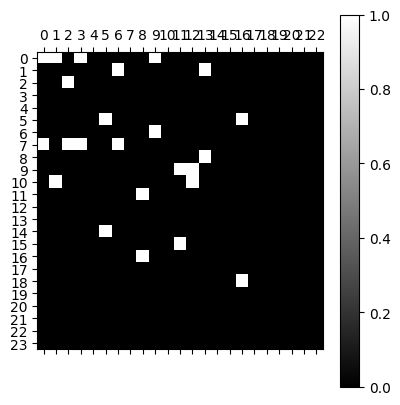

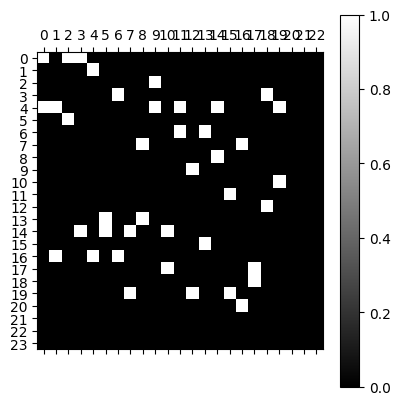

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


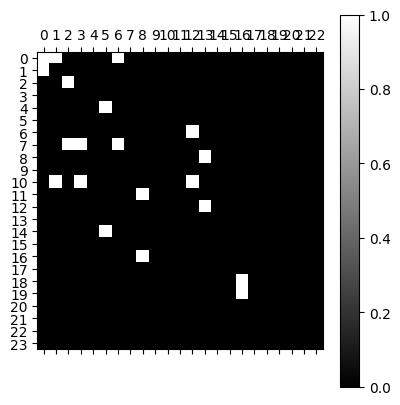

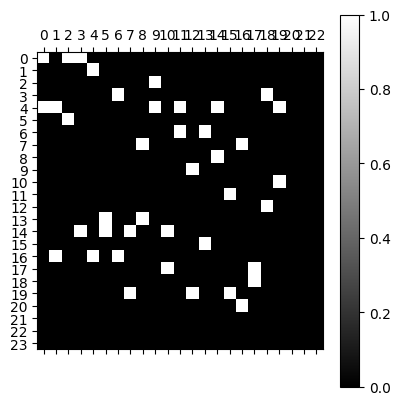

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


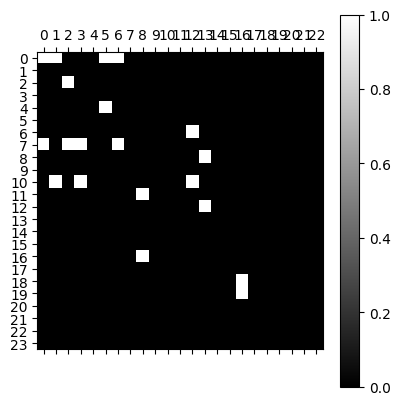

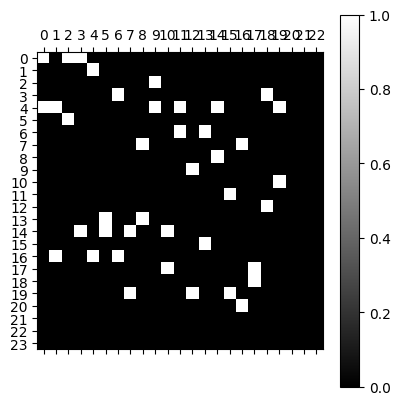

 Resultados 
[56.0, 56.0, 58.0]
[]
[-39.0, -39.0, -41.0]
-119.0
51
0.0


In [90]:
results =[]
interval=2

import joblib
model_output_path ="../Modelos/{}"
model_cargado5 = joblib.load(model_output_path.format("model_lstm_cnn-mask-zeros-001D"))

models = {
    "model_test":model_cargado5,
        }

type_output = 2
number_eval = int(len(X)/3)

print("*************** Validacion modelos ******************")
print(f"************ Casos de pruebas  {number_eval} *******")
number_eval = 1
for model_name , model_val in models.items() :
    print(f" modelo evaluado {model_name}")
    results = []
    for index in range(3) : 
        predicted_image = model_val.predict(X)
        test_image = predicted_image[index][interval]

        data_out = []
        for i in range(test_image.shape[0]):
            row = []
            for j in range(test_image.shape[1]):
                # val = 1 if np.abs((test_image[i, j])) > 0.4 else 0
                val = test_image[i, j]
                row.append(val)
            data_out.append(row)

        df_topo_out = pd.DataFrame(data_out, columns=[f'{i}' for i in range(test_image.shape[1])])
        # print(df_topo_out)
        # print_bw_matrix(df_topo_out)
        df_topo_out = ajustar_celdas(df_topo_out)
        plot_and_print_result(df_topo_out,type_output=type_output)


        test_image_val = Y[index][interval]
        data_val = []
        for i in range(test_image_val.shape[0]):
            row = []
            for j in range(test_image_val.shape[1]):
                row.append(np.abs(np.round(test_image_val[i, j])))
            data_val.append(row)

        df_topo_val = pd.DataFrame(data_val, columns=[f'{i}' for i in range(test_image_val.shape[1])])

        plot_and_print_result(df_topo_val ,"Test Model Data",type_output=type_output)
        result = comparar_matrices(df_topo_out,df_topo_val)
        results.append(result)

    val_reuslt = ([True for result in results if result == lines])
    val_reuslt_sum = ([lines-result for result in results ])
    print("="*30)
    print(" Resultados ")
    print((results))
    print((val_reuslt))
    print((val_reuslt_sum))
    print(sum(val_reuslt_sum))
    print(len(results)*lines)
    print(len(val_reuslt)/len(results))
    print("="*30)